### Notebook
- Creates Figure S1: Overview of pan-cancer cohort (sex/age)

In [1]:
import pandas as pd
import numpy as np
import os

from scipy.stats import mannwhitneyu, fisher_exact, ks_2samp

import matplotlib.pyplot as plt
from matplotlib import gridspec 
import seaborn as sns
sns.set_style('white')
%matplotlib inline

### 0. Global variables

In [2]:
MSS = 'MSS_only' 
mss_patients = np.loadtxt('../data/mss_tcga_patients.txt', dtype=str)

### 1. Load patients

In [3]:
# Remove sex-specific cancers for sex-specific analyses
print('Loading confident {} patients with removed sex-specific cancers '.format(MSS))
confident_patients_I_rm_sex_specific = pd.read_csv('../generated_data/confident_patient_I.age_sex_disease.{}.remove_sex_specific.tsv'.format(MSS), sep='\t', index_col=0)
confident_patients_II_rm_sex_specific = pd.read_csv('../generated_data/confident_patient_II.age_sex_disease.{}.remove_sex_specific.tsv'.format(MSS), sep='\t', index_col=0)

print('{} confident MHC-I, {} confident MHC-II'.format(len(set(confident_patients_I_rm_sex_specific.index)), 
                                                       len(set(confident_patients_II_rm_sex_specific.index))))
confident_patients_I_rm_sex_specific.head(2)

Loading confident MSS_only patients with removed sex-specific cancers 
2554 confident MHC-I, 2681 confident MHC-II


,scores,disease,age,sex
TCGA-85-8580,0.120879,LUSC,52.0,female
TCGA-IB-AAUM,1.249676,PAAD,76.0,male


In [4]:
# Keep sex-specific cancers for age-specific analyses
print('Loading confident {} patients with kept sex-specific cancers'.format(MSS))
confident_patients_I_kept_sex_specific = pd.read_csv('../generated_data/confident_patient_I.age_sex_disease.{}.kept_sex_specific.tsv'.format(MSS), sep='\t', index_col=0)
confident_patients_II_kept_sex_specific = pd.read_csv('../generated_data/confident_patient_II.age_sex_disease.{}.kept_sex_specific.tsv'.format(MSS), sep='\t', index_col=0)

print('{} confident MHC-I, {} confident MHC-II'.format(len(set(confident_patients_I_kept_sex_specific.index)), 
                                                       len(set(confident_patients_II_kept_sex_specific.index))))
confident_patients_I_kept_sex_specific.head(2)

Loading confident MSS_only patients with kept sex-specific cancers
3166 confident MHC-I, 3036 confident MHC-II


,scores,disease,age,sex
TCGA-85-8580,0.120879,LUSC,52.0,female
TCGA-A5-A0GV,3.524218,UCEC,67.0,female


### 2. Plot Figure S1

##### 2A. Aggregate patients
- Get all unique patients from confidently typed patients with MHC-I and MHC-II

In [5]:
# Pool patients with removed sex-specific cancers (sex analysis)
total_rm_sex_specific_df = confident_patients_I_rm_sex_specific.copy()
total_rm_sex_specific_df = total_rm_sex_specific_df.append(confident_patients_II_rm_sex_specific)
total_rm_sex_specific_df.reset_index(inplace=True)
total_rm_sex_specific_df.drop_duplicates(subset=['index'], inplace=True)

total_rm_sex_specific_df.head(2)

,index,scores,disease,age,sex
0,TCGA-85-8580,0.120879,LUSC,52.0,female
1,TCGA-IB-AAUM,1.249676,PAAD,76.0,male


In [6]:
# Pool patients with kept sex-specific cancers (age analysis)
total_kept_sex_specific_df = confident_patients_I_kept_sex_specific.copy()
total_kept_sex_specific_df = total_kept_sex_specific_df.append(confident_patients_II_kept_sex_specific)
total_kept_sex_specific_df.reset_index(inplace=True)
total_kept_sex_specific_df.drop_duplicates(subset=['index'], inplace=True)

total_kept_sex_specific_df.head(2)

,index,scores,disease,age,sex
0,TCGA-85-8580,0.120879,LUSC,52.0,female
1,TCGA-A5-A0GV,3.524218,UCEC,67.0,female


##### 2B. Load SEER data

In [7]:
# Population statistics
seer_tcga_df = pd.read_csv('../data/SEER_sex_age_stats_TCGA_only.txt', sep='\t',
                           comment='#', index_col=0)
seer_sex_df = seer_tcga_df[seer_tcga_df.columns[:2]]
seer_sex_df.head(2)

,male,female
bladder,35.2,8.7
brain and other nervous system,7.5,5.4


In [8]:
# Prepare SEER data
sex_specific_types = seer_sex_df[seer_sex_df.isnull().any(axis=1)].index.values
print('Dropping {}'.format(sex_specific_types))
seer_sex_df = seer_sex_df.dropna()
seer_sex_df

Dropping ['breast' 'cervix uteri' 'ovary' 'prostate' 'testis' 'uterus']


,male,female
bladder,35.2,8.7
brain and other nervous system,7.5,5.4
colon and rectum,44.2,33.9
esophagus,7.3,1.8
kidney and renal pelvis,22.1,10.9
liver and intrahepatic bile duct,13.6,4.7
lung and bronchus,63.0,48.9
diffuse large B-Cell lymphoma,6.7,4.6
acute myeloid leukemia,5.2,3.5
chronic myeloid leukemia,2.4,1.4


In [9]:
# aggregate, then make ratios
seer_sex_df = seer_sex_df.sum(axis=0)
seer_sex_df

male      268.6
female    181.4
dtype: float64

In [10]:
# TCGA ratios
tcga_sex_df = total_rm_sex_specific_df.pivot_table(index='sex', values='index', aggfunc='count')
tcga_sex_df

,index
sex,
female,1369
male,1954


In [11]:
fisher_df = pd.DataFrame([[seer_sex_df.male, seer_sex_df.female],
                          [tcga_sex_df.loc['male']['index'], tcga_sex_df.loc['female']['index']]],
                        columns=['male','female'], index=['SEER','TCGA'])
fisher_df

,male,female
SEER,268.6,181.4
TCGA,1954.0,1369.0


In [12]:
fisher_exact(fisher_df)

(1.0373734003630461, 0.759190483564455)

Saving to ../figures/S1.sex_age_counts.with_SEER.MSS_only.pdf


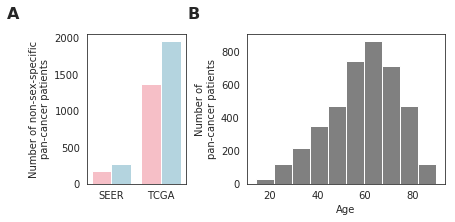

In [14]:
plt.figure(figsize=(6,5))
gs = gridspec.GridSpec(2, 2, width_ratios=[1.4, 2.8]) 

############################
# A - pancancer sex counts #
############################

plt.subplot(gs[0])
data = pd.melt(fisher_df.reset_index(), id_vars=['index'])
data = data.rename(columns={'variable':'Sex'})
ax = sns.barplot(hue='Sex', y='value', data=data, x='index', hue_order=['female','male'],
                 palette=['lightpink','lightblue'])
plt.xlabel(''), plt.ylabel('Number of non-sex-specific\npan-cancer patients')
ax.legend_.remove()

# data = pd.DataFrame(total_rm_sex_specific_df['sex'].value_counts()).T
# ax = sns.barplot(data=data, order=['female', 'male'], palette=['pink', 'lightblue'])
# plt.xlabel('Sex'), plt.ylabel('Number of non-sex-specific\npan-cancer patients')
# plt.xticks([0,1], ['Female', 'Male'])
plt.text(-0.8, 1.1, 'A', transform=ax.transAxes, fontsize=16,  weight='bold')

##################################
# B - pancancer age distribution #
##################################

fig = plt.subplot(gs[1])
plt.hist(x=total_kept_sex_specific_df['age'].values, bins=10, color='grey')
plt.xlabel('Age')
plt.ylabel('Number of\npan-cancer patients')
plt.yticks(range(0,801,200))
plt.text(-0.3, 1.1, 'B', transform=fig.transAxes, fontsize=16,  weight='bold')

plt.tight_layout(pad=0.6, h_pad=1)

savepath = '../figures/S1.sex_age_counts.with_SEER.{}.pdf'.format(MSS)
print('Saving to {}'.format(savepath))
plt.savefig(savepath, bbox_inches='tight')
plt.show()